In [1]:
%matplotlib notebook

import json
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

from ast import literal_eval

In [2]:
INIT_STOP = 200
TSTOP = 1200
NTRAJ = 64
NPOINTS = 120
THRES = 0.1
BURN_IN = 20

In [3]:
with open('data.json', 'r') as f:
    raw_data = {literal_eval(k): v for k, v in json.load(f).items()}
    
for key in raw_data.keys():
    solver, params = key
    timeseries = raw_data[key][1]
            
    if solver == 'CBM':
        for species in ['P', 'RNA']:
            timeseries[species] = np.array(timeseries[species + 'nuc']) + np.array(timeseries[species + 'cyt'])
            del timeseries[species + 'nuc']
            del timeseries[species + 'cyt']
    
    del timeseries['Gf']
    del timeseries['Gb']
    
    for species in timeseries:
        timeseries[species] = np.array(timeseries[species])[:, BURN_IN:]

In [4]:
summary_statistics_raw = {
        'mean': lambda x: np.mean(x),
        'std': lambda x: np.std(x),
        'min': lambda x: np.min(x),
        'max': lambda x: np.max(x),
        }

stat_mean = {k + species: np.mean([s(v[1][species]) for v in raw_data.values()])
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']}

stat_std = {k + species: np.std([s(v[1][species]) for v in raw_data.values()])
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']}

summary_statistics = {
            k + species: lambda x: (s(x) - stat_mean[k + species])/stat_std[k + species]
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']
        }

lst_square = lambda x,y: (
        (np.array([summary_statistics[k + species](x[species])
                   for k in summary_statistics_raw.keys()
                   for species in ['P', 'RNA']])
        - (np.array([summary_statistics[k + species](y[species])
                   for k in summary_statistics_raw.keys()
                   for species in ['P', 'RNA']]))
    )**2).sum()**0.5

In [5]:
# Refactor data
data = {}
for k, v in raw_data.items():
    solver, params = k
    data.setdefault(params, {})[solver] = v

In [6]:
# SS and KG for CBM
ss_dist = {solver:
           {k:
              lst_square(v['smoldyn'][1], v[solver][1])
              for k, v in data.items()
              if 'smoldyn' in v and solver in v
              }
           for solver in ['CBM', 'WMM']
          }

ks_dist = {solver :
           {k:
              sum([
                  scs.ks_2samp(v['smoldyn'][1][species].reshape(-1), v[solver][1][species].reshape(-1))[0]
                  for species in ['P', 'RNA']])/2
              for k, v in data.items()
              if 'smoldyn' in v and solver in v
              }
           for solver in ['CBM', 'WMM']
          }

<IPython.core.display.Javascript object>


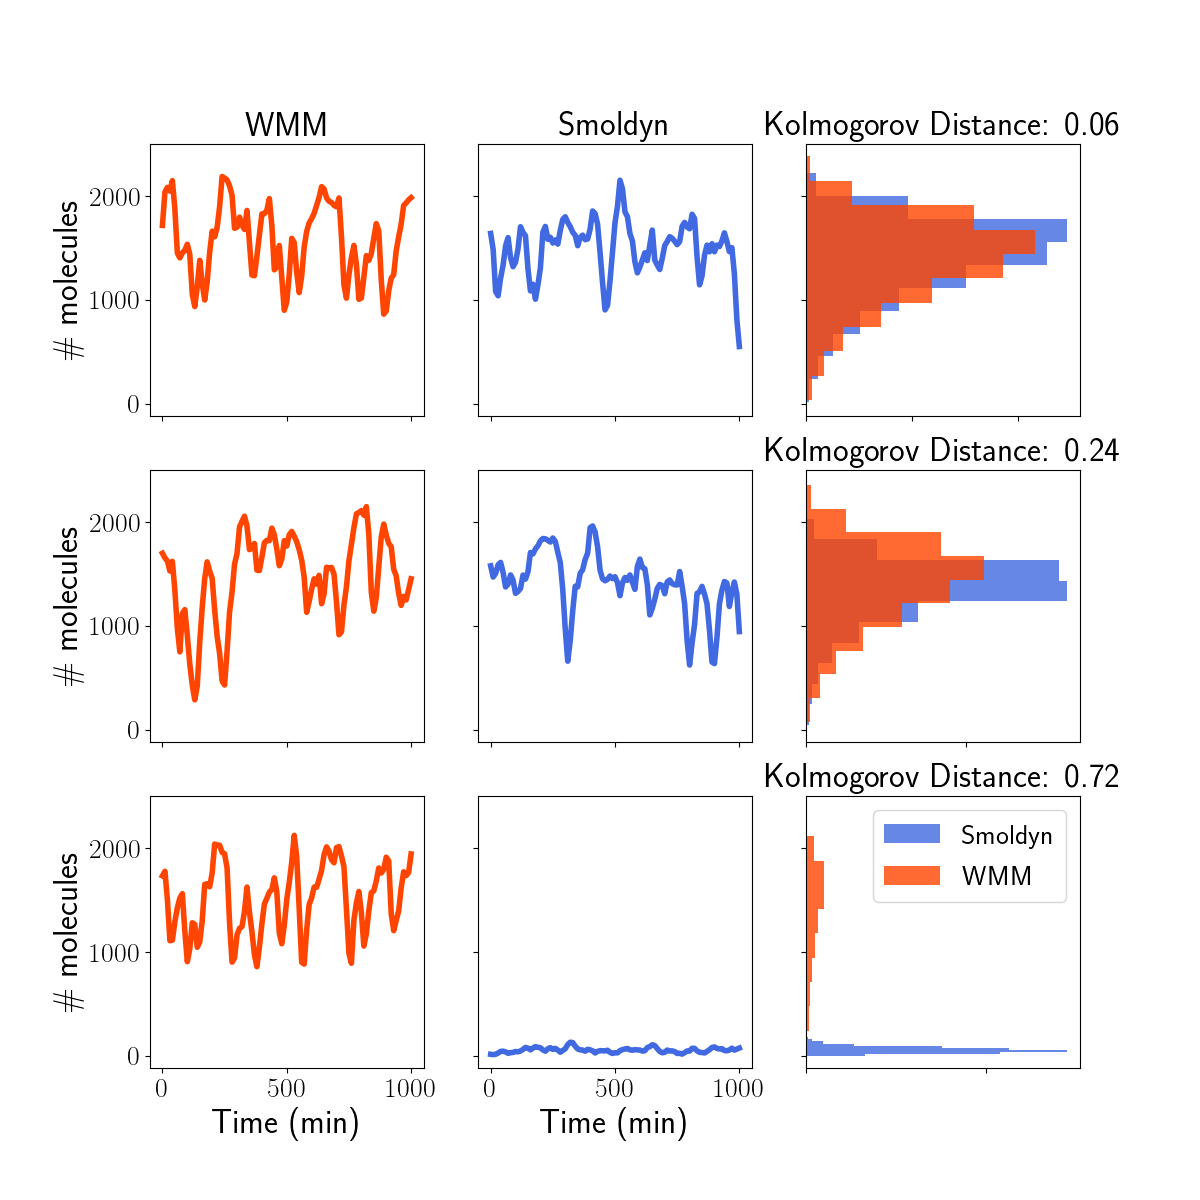

<IPython.core.display.Javascript object>


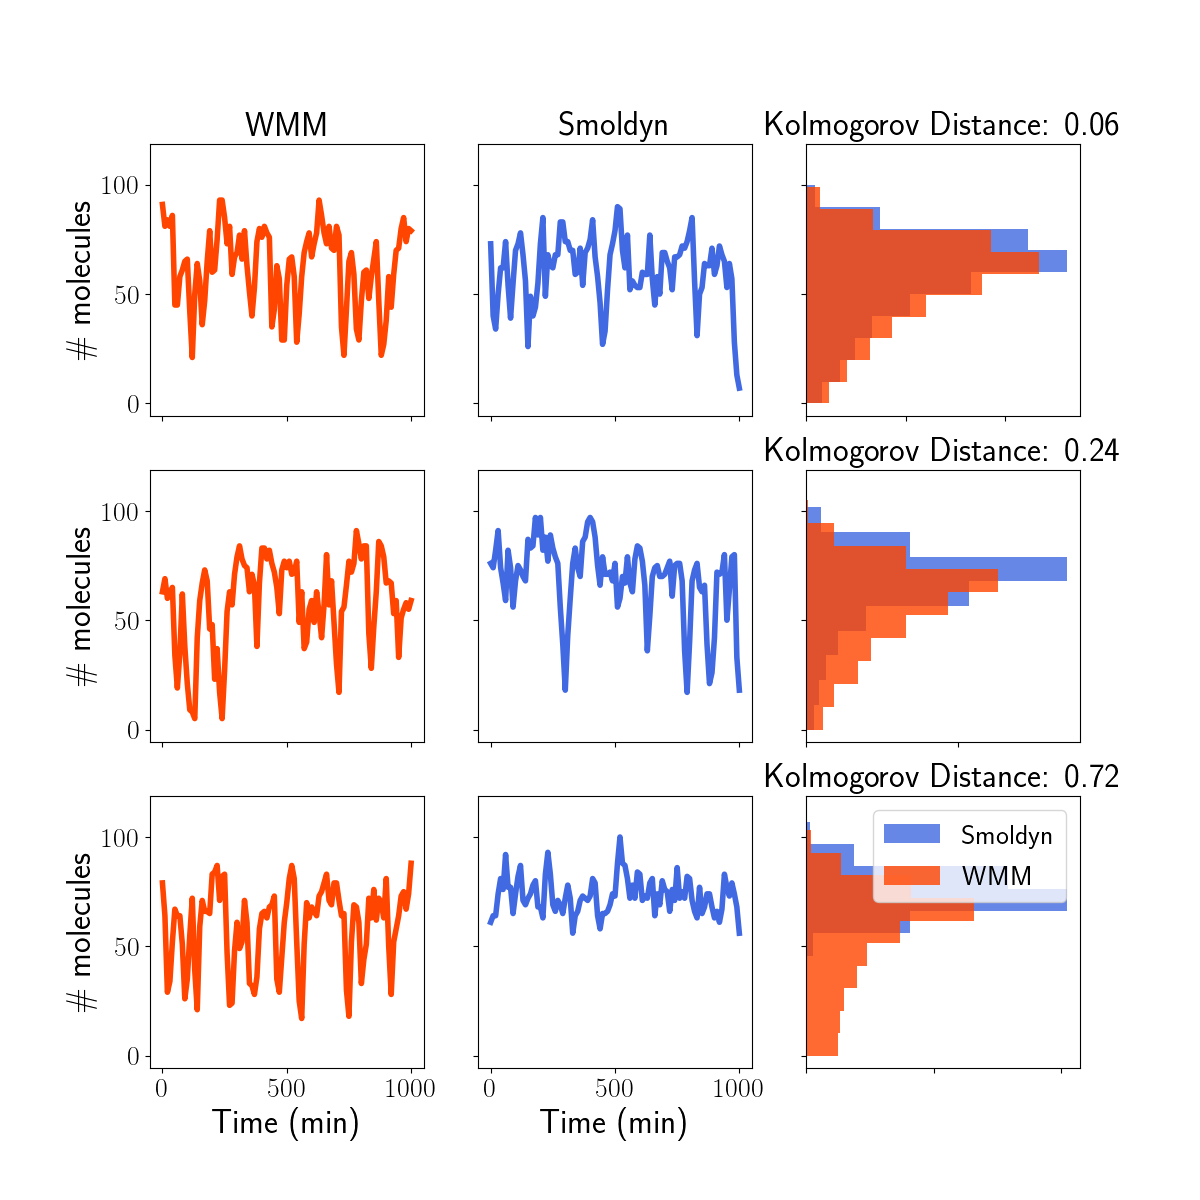

In [7]:
params = {'legend.fontsize': 20,
          'figure.figsize': (12, 12),
         #'figure.figsize': (10, 10),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'text.usetex':True
         }

plt.rcParams.update(params)

keys = sorted([k for k in data.keys() if k[2] == 0.0], key=lambda k: (k[1], k[0]))
keys = [keys[i] for i in [125, 121, 115]]

alpha = 1
width = 4

for species in ['P', 'RNA']:
    fig, ax = plt.subplots(3, 3, sharey=True)
    for i, key in enumerate(keys):
            t = np.linspace(0, TSTOP - INIT_STOP, num=NPOINTS - BURN_IN + 1)
            ax[i, 0].plot(t, np.array(data[key]['WMM'][1][species])[0, :].T,
                              'orangered', label=species, linewidth=width, alpha=alpha)
            ax[i, 1].plot(t, np.array(data[key]['smoldyn'][1][species])[0, :].T,
                              'royalblue', label=species, linewidth=width, alpha=alpha)

            ax[i, 0].set_ylabel(r'\# molecules')
            for j in [0, 1]:    
                #ax[i, j].set_ylim(0, 2500)
                if i == 2:
                    ax[i, j].set_xlabel('Time (min)')
                else:
                    ax[i, j].set_xticklabels([])

            if not i:
                ax[i, 0].set_title('WMM')
                ax[i, 1].set_title('Smoldyn')
            if i == 2:
                pass
                #ax[i, 1].legend(loc=0)

            ax[i, 2].hist(np.array(data[key]['smoldyn'][1][species]).reshape(-1),
                               histtype='stepfilled',
                               fill=True,
                               alpha=.8,
                               label='Smoldyn',
                               density=True,
                               orientation='horizontal',
                               color='royalblue',
                              )
            ax[i, 2].hist(np.array(data[key]['WMM'][1][species]).reshape(-1),
                               histtype='stepfilled',
                               fill=True,
                               alpha=.8,
                               label='WMM',
                               density=True,
                               orientation='horizontal',
                               color='orangered',
                              )

            ax[i, 2].set_xticklabels([])
            #ax[i, 2].set_ylim(0, 2500)
            ax[i, 2].set_title("Kolmogorov Distance: {:.2f}".format(ks_dist['WMM'][key]))

            if i == 2:
                ax[i, 2].legend(loc=0)                

    plt.savefig(f"traj_example_{species}.pdf")

In [8]:
keys = sorted([k for k in data.keys() if k[2] == 0.0], key=lambda k: (k[1], k[0]))
for i, key in enumerate(keys):
    print(i, key)

0 (-8.0, -2.0, 0.0)
1 (-7.2, -2.0, 0.0)
2 (-6.4, -2.0, 0.0)
3 (-5.6, -2.0, 0.0)
4 (-4.8, -2.0, 0.0)
5 (-4.0, -2.0, 0.0)
6 (-3.1999999999999993, -2.0, 0.0)
7 (-2.3999999999999995, -2.0, 0.0)
8 (-1.5999999999999996, -2.0, 0.0)
9 (-0.7999999999999998, -2.0, 0.0)
10 (0.0, -2.0, 0.0)
11 (0.8000000000000007, -2.0, 0.0)
12 (1.6000000000000014, -2.0, 0.0)
13 (2.4000000000000004, -2.0, 0.0)
14 (3.200000000000001, -2.0, 0.0)
15 (4.0, -2.0, 0.0)
16 (-8.0, -1.6, 0.0)
17 (-7.2, -1.6, 0.0)
18 (-6.4, -1.6, 0.0)
19 (-5.6, -1.6, 0.0)
20 (-4.8, -1.6, 0.0)
21 (-4.0, -1.6, 0.0)
22 (-3.1999999999999993, -1.6, 0.0)
23 (-2.3999999999999995, -1.6, 0.0)
24 (-1.5999999999999996, -1.6, 0.0)
25 (-0.7999999999999998, -1.6, 0.0)
26 (0.0, -1.6, 0.0)
27 (0.8000000000000007, -1.6, 0.0)
28 (1.6000000000000014, -1.6, 0.0)
29 (2.4000000000000004, -1.6, 0.0)
30 (3.200000000000001, -1.6, 0.0)
31 (4.0, -1.6, 0.0)
32 (-8.0, -1.2, 0.0)
33 (-7.2, -1.2, 0.0)
34 (-6.4, -1.2, 0.0)
35 (-5.6, -1.2, 0.0)
36 (-4.8, -1.2, 0.0)
37 (-4.